In [49]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, OrdinalEncoder, MinMaxScaler, RobustScaler, MaxAbsScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from sklearn.utils.class_weight import compute_class_weight


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

from xgboost import XGBClassifier, XGBRegressor
import xgboost as xgb
from tpot import TPOTClassifier

In [50]:
features_num = [
    'Total_flux', 'Peak_flux', 
       'NUV_flux_corr', 'u_flux_corr', 'Bw_flux_corr', 'R_flux_corr',
       'I_flux_corr', 'z_flux_corr', 'y_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'K_flux_corr', 'Ks_flux_corr',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'Z_BEST',
       'g_flux_corr', 'nb921_hsc_flux_corr'
    ]
y_column = "Classification"

classes = ['jet-mode radio AGN/low-excitation radio galaxy', 'quasar-like radio AGN / high-excitation radio galaxy', 
           'radio-quiet AGN', 'star-forming galaxy']

In [51]:
data = pd.read_csv("../../../Data/Fangyou_data/Cleaned/combined_using_similar_columns.csv")
data['Source'] = 'Original'

In [52]:
X = data[features_num]
y = data[[y_column, 'Source', 'Xray', 'Opt_spec', 'IRAGN', 'Donley']]

In [53]:
le = LabelEncoder()
labels = np.unique(y["Classification"].astype(str))
y["Classification"] = le.fit_transform(y["Classification"])

/var/lib/condor/execute/dir_2918266/ipykernel_2918405/2943677748.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Classification"] = le.fit_transform(y["Classification"])


In [54]:
# -1 in the LOFAR deep fields should become nans since they are factually nans
for c in ['Xray', 'Opt_spec', 'IRAGN', 'Donley']:
    y[c][y[c]==-1]=np.nan
    y[c][y[c] == 1] = True
    y[c][y[c] == 0] = False

/var/lib/condor/execute/dir_2918266/ipykernel_2918405/975002904.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[c][y[c]==-1]=np.nan
/Software/users/modules/7/software/anaconda3/2021.11/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/var/lib/condor/execute/dir_2918266/ipykernel_2918405/975002904.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-

## BH data

In [55]:
Best_Heckman_data = pd.read_csv("../../../Data/Best&Heckman/BestHeckman+SDSS+wise+LOFAR_better.csv")
Best_Heckman_data['Source'] = 'BH'

In [56]:
# Only selecting data with a classification
Best_Heckman_data = Best_Heckman_data[Best_Heckman_data['Classification'] != 'Radio-loud AGN'] 

In [57]:
Best_Heckman_X = Best_Heckman_data[[c for c in Best_Heckman_data.columns if c != 'Classification']]
Best_Heckman_y = Best_Heckman_data[['Classification', 'Source']]

In [58]:
Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])

/var/lib/condor/execute/dir_2918266/ipykernel_2918405/4234724966.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Best_Heckman_y['Classification'] = le.transform(Best_Heckman_y['Classification'])


In [59]:
y = pd.concat([y, Best_Heckman_y]).reset_index(drop=True)

In [60]:
Best_Heckman_X = Best_Heckman_X[['Z_BEST', 'u_flux_corr',
       'g_flux_corr', 'R_flux_corr', 'I_flux_corr', 'z_flux_corr', 'ch1_flux_corr', 'ch2_flux_corr',
       'J_flux_corr', 'H_flux_corr', 'Ks_flux_corr', 'Peak_flux', 'Total_flux']]

# Adding nans to missing columns
Best_Heckman_X[['NUV_flux_corr', 'Bw_flux_corr', 'y_flux_corr', 'K_flux_corr', 
                'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
                'F_SPIRE_500', 'nb921_hsc_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr']] = np.nan

In [61]:
X = pd.concat([X, Best_Heckman_X]).reset_index(drop=True)

### MIGHTEE data

In [62]:
mightee_data = pd.read_csv("../../../Data/MIGHTEE/Classification/final_gaussian_radio_more.csv")
mightee_data['Source'] = 'MIGHTEE'

In [63]:
mightee_data.columns

Index(['Unnamed: 0', 'S_INT14', 'Z_BEST', 'S_PEAK14', 'Classification',
       'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr', 'ch4_flux_corr',
       'F_MIPS_24', 'F_PACS_100', 'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350',
       'F_SPIRE_500', 'EBV', 'Ks_flux_corr', 'H_flux_corr', 'J_flux_corr',
       'i_flux_corr', 'r_flux_corr', 'u_flux_corr', 'z_flux_corr',
       'y_flux_corr', 'NUV_flux_corr', 'FUV_flux_corr', 'Total_flux',
       'Peak_flux', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN',
       'Source'],
      dtype='object')

In [64]:
# Dropping nan classifications
mightee_data = mightee_data[mightee_data['Classification'].notna()]

# Dropping quasar-like radio AGN / high-excitation radio galaxy
#mightee_data = mightee_data[mightee_data['Classification'] != 'star-forming galaxy']
print("Amount of rows:", len(mightee_data))

Amount of rows: 4370


In [65]:
mightee_X = mightee_data[[c for c in mightee_data.columns if c != 'Classification']]
mightee_y = mightee_data[['Classification', 'Source', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']]

In [66]:
mightee_y['Classification'] = le.transform(mightee_y['Classification'])
y = pd.concat([y, mightee_y]).reset_index(drop=True)

/var/lib/condor/execute/dir_2918266/ipykernel_2918405/4111256676.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mightee_y['Classification'] = le.transform(mightee_y['Classification'])


In [67]:
mightee_X = mightee_X[['Z_BEST', 'ch1_flux_corr', 'ch2_flux_corr', 'ch3_flux_corr',
       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 'F_PACS_160',
       'F_SPIRE_250', 'F_SPIRE_350', 'F_SPIRE_500', 'Ks_flux_corr',
       'H_flux_corr', 'J_flux_corr', 'i_flux_corr', 'r_flux_corr',
       'u_flux_corr', 'z_flux_corr', 'y_flux_corr', 'NUV_flux_corr',
       #'FUV_flux_corr', 
                       'Total_flux', 'Peak_flux']]

mightee_X[['I_flux_corr', 'R_flux_corr']] = mightee_X[['i_flux_corr', 'r_flux_corr']]
mightee_X = mightee_X.drop(columns=['i_flux_corr', 'r_flux_corr'])

# Adding nans to missing columns
mightee_X[['Bw_flux_corr', 'K_flux_corr', 'g_flux_corr', 'nb921_hsc_flux_corr']] = np.nan

# Changing order
mightee_X = mightee_X[['Total_flux', 'Peak_flux', 
                       'NUV_flux_corr', 'u_flux_corr', 
                       'Bw_flux_corr', 'R_flux_corr', 
                       'I_flux_corr', 'z_flux_corr', 
                       'y_flux_corr', 'J_flux_corr', 
                       'H_flux_corr', 'K_flux_corr', 
                       'Ks_flux_corr', 'ch1_flux_corr', 
                       'ch2_flux_corr', 'ch3_flux_corr', 
                       'ch4_flux_corr', 'F_MIPS_24', 'F_PACS_100', 
                       'F_PACS_160', 'F_SPIRE_250', 'F_SPIRE_350', 
                       'F_SPIRE_500', 'Z_BEST', 
                       'g_flux_corr', 'nb921_hsc_flux_corr']]

In [69]:
X = pd.concat([X, mightee_X]).reset_index(drop=True)

### Generate more features

In [48]:
# Creating new features
columns = X.columns
for i in range(len(columns)):
    if columns[i]!='Z_BEST':
        for j in range(i+1, len(columns)):
            if columns[j]!='Z_BEST':
                X[f"{columns[i]}/{columns[j]}"] = X[columns[i]]/X[columns[j]]
                X[f"{columns[i]}-{columns[j]}"] = X[columns[i]]-X[columns[j]]

/var/lib/condor/execute/dir_1566830/ipykernel_1567984/2770299810.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{columns[i]}-{columns[j]}"] = X[columns[i]]-X[columns[j]]
/var/lib/condor/execute/dir_1566830/ipykernel_1567984/2770299810.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f"{columns[i]}/{columns[j]}"] = X[columns[i]]/X[columns[j]]


### Alternatively

In [70]:
X['ch1/ch2'] = X['ch1_flux_corr']/X['ch2_flux_corr']
X['ch2/ch3'] = X['ch2_flux_corr']/X['ch3_flux_corr']
X['ch3/ch4'] = X['ch3_flux_corr']/X['ch4_flux_corr']
X['ch3/ch4'] = X['ch3_flux_corr']/X['ch4_flux_corr']
X['r/J'] = X['R_flux_corr']/X['J_flux_corr']
X['u/r'] = X['u_flux_corr']/X['R_flux_corr']
X['g/r'] = X['g_flux_corr']/X['R_flux_corr']

## Running the model

In [21]:
# Creating training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.8, stratify=y_test, random_state=42)

from sklearn.utils import class_weight
classes_weights = class_weight.compute_sample_weight(
    class_weight='balanced',
    y=y_train
)

In [22]:
from sklearn.metrics import precision_score

def precision_metric(y_true, y_pred):
    y_pred = y_pred.get_label()

    # Since we are using softprob
    y_true = np.argmax(y_true, axis=1)
    
    return 'precision', -precision_score(y_true, y_pred, average='macro')

In [23]:
model = XGBClassifier(use_label_encoder=False, 
                      max_depth=6, 
                      #reg_alpha=1.3,   
                      #min_child_weight=5, 
                      #reg_lambda=0.86,
                      max_delta_step=0.3,
                      eta=0.4, # Remember to reduce to 0.1 or 0.05 for better results
                      #gamma=0.1,
                      tree_method='hist', # exact is more precies, but this is much faster
                      #gpu_id=0,
                      eval_metric=['merror'],
                      objective='multi:softprob',
                      #feval=precision_metric,
                      nthread=8,
                      n_estimators=10000,
                      )

In [52]:
bst = model.fit(X_train, y_train, 
                eval_set=[
                    (X_train, y_train),
                    (X_val, y_val)
                ], 
                early_stopping_rounds=100,
                verbose=True, 
                #sample_weight=classes_weights,
                #eval_metric=precision_metric
               ) #

[0]	validation_0-merror:0.15074	validation_1-merror:0.17000
[1]	validation_0-merror:0.14757	validation_1-merror:0.16816
[2]	validation_0-merror:0.13961	validation_1-merror:0.16027
[3]	validation_0-merror:0.13496	validation_1-merror:0.15581
[4]	validation_0-merror:0.12970	validation_1-merror:0.15160
[5]	validation_0-merror:0.12627	validation_1-merror:0.14976
[6]	validation_0-merror:0.12290	validation_1-merror:0.14687
[7]	validation_0-merror:0.11672	validation_1-merror:0.14057
[8]	validation_0-merror:0.11320	validation_1-merror:0.13715
[9]	validation_0-merror:0.11099	validation_1-merror:0.13505
[10]	validation_0-merror:0.10822	validation_1-merror:0.13163
[11]	validation_0-merror:0.10620	validation_1-merror:0.12901
[12]	validation_0-merror:0.10370	validation_1-merror:0.12743
[13]	validation_0-merror:0.10206	validation_1-merror:0.12638
[14]	validation_0-merror:0.10012	validation_1-merror:0.12428
[15]	validation_0-merror:0.09804	validation_1-merror:0.12296
[16]	validation_0-merror:0.09635	v

[134]	validation_0-merror:0.01933	validation_1-merror:0.09643
[135]	validation_0-merror:0.01897	validation_1-merror:0.09643
[136]	validation_0-merror:0.01885	validation_1-merror:0.09643
[137]	validation_0-merror:0.01850	validation_1-merror:0.09643
[138]	validation_0-merror:0.01842	validation_1-merror:0.09643
[139]	validation_0-merror:0.01825	validation_1-merror:0.09695
[140]	validation_0-merror:0.01797	validation_1-merror:0.09721
[141]	validation_0-merror:0.01792	validation_1-merror:0.09774
[142]	validation_0-merror:0.01768	validation_1-merror:0.09774
[143]	validation_0-merror:0.01717	validation_1-merror:0.09774
[144]	validation_0-merror:0.01667	validation_1-merror:0.09800
[145]	validation_0-merror:0.01645	validation_1-merror:0.09748
[146]	validation_0-merror:0.01610	validation_1-merror:0.09748
[147]	validation_0-merror:0.01575	validation_1-merror:0.09748
[148]	validation_0-merror:0.01545	validation_1-merror:0.09643
[149]	validation_0-merror:0.01523	validation_1-merror:0.09695
[150]	va

[267]	validation_0-merror:0.00172	validation_1-merror:0.09721
[268]	validation_0-merror:0.00167	validation_1-merror:0.09643
[269]	validation_0-merror:0.00163	validation_1-merror:0.09695
[270]	validation_0-merror:0.00162	validation_1-merror:0.09669
[271]	validation_0-merror:0.00159	validation_1-merror:0.09590
[272]	validation_0-merror:0.00155	validation_1-merror:0.09564
[273]	validation_0-merror:0.00154	validation_1-merror:0.09538
[274]	validation_0-merror:0.00152	validation_1-merror:0.09616
[275]	validation_0-merror:0.00148	validation_1-merror:0.09721
[276]	validation_0-merror:0.00148	validation_1-merror:0.09695


AttributeError: 'XGBClassifier' object has no attribute 'cv'

In [58]:
y_pred = model.predict(X_val)
print(classification_report(y_val, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9060    0.8722    0.8888       939
quasar-like radio AGN / high-excitation radio galaxy     0.7436    0.3537    0.4793        82
                                     radio-quiet AGN     0.8059    0.6564    0.7235       291
                                 star-forming galaxy     0.9162    0.9647    0.9398      2494

                                            accuracy                         0.9051      3806
                                           macro avg     0.8429    0.7117    0.7579      3806
                                        weighted avg     0.9015    0.9051    0.9008      3806



In [59]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8959    0.8708    0.8832      3754
quasar-like radio AGN / high-excitation radio galaxy     0.5843    0.2948    0.3919       329
                                     radio-quiet AGN     0.7729    0.6455    0.7035      1165
                                 star-forming galaxy     0.9170    0.9593    0.9377      9975

                                            accuracy                         0.8991     15223
                                           macro avg     0.7925    0.6926    0.7291     15223
                                        weighted avg     0.8936    0.8991    0.8945     15223



### Probabilities

In [503]:
# Checking probability ranges and how accurate they are
range_beginning = np.array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
increase = 0.1


all_accuracies = []
all_samples = []
for c in range(4):
    class_accuracies = []
    class_sample = []
    class_type = c
    for i in range_beginning:
        # Filter for class
        filt_class = y_test == class_type

        prob = model.predict_proba(X_test)
        prob_max = np.max(prob, axis=1)
        filt_prob = (prob_max>i) & (prob_max<=(i+increase))

        y_pred = model.predict(X_test)[filt_prob & filt_class]
        y_test_filt = y_test[filt_prob & filt_class]

        # Fraction that is correctly predicted
        class_accuracies.append(sum(y_pred == y_test_filt)/len(y_pred))
        class_sample.append(len(y_pred))
    all_accuracies.append(class_accuracies)
    all_samples.append(class_sample)

[4, 20, 159, 186, 223, 317, 2697]


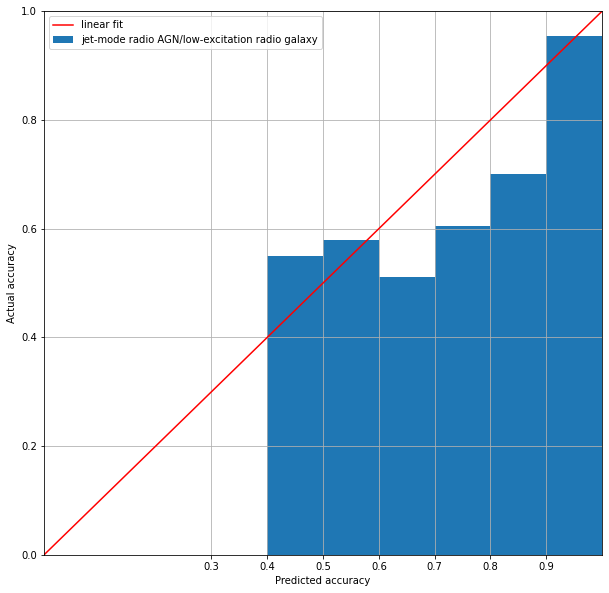

In [532]:
plt.figure(figsize=(10,10))
plt.bar(range_beginning+0.05, all_accuracies[0], width=0.1, label=labels[0])
plt.plot([0,1],[0,1], c='r', label='linear fit')
plt.grid()
plt.xticks(range_beginning)
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

print(all_samples[0])

[7, 15, 33, 38, 43, 41, 113]


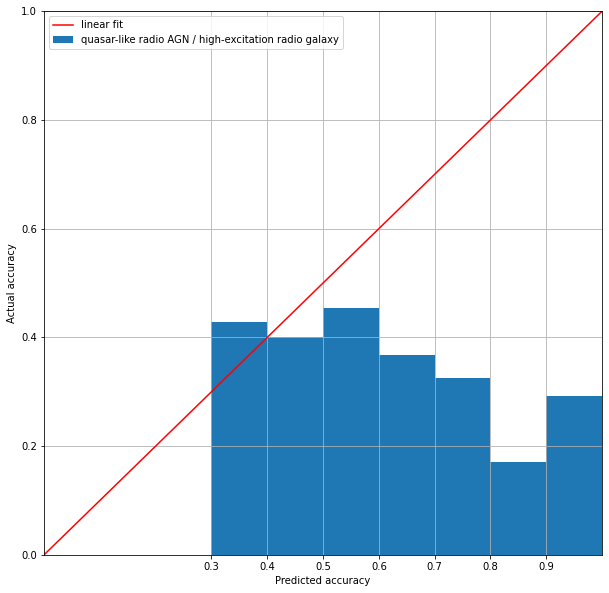

In [534]:
plt.figure(figsize=(10,10))
plt.bar(range_beginning+0.05, all_accuracies[1], width=0.1, label=labels[1])
plt.plot([0,1],[0,1], c='r', label='linear fit')
plt.grid()
plt.xticks(range_beginning)
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

print(all_samples[1])

[5, 13, 104, 130, 134, 209, 504]


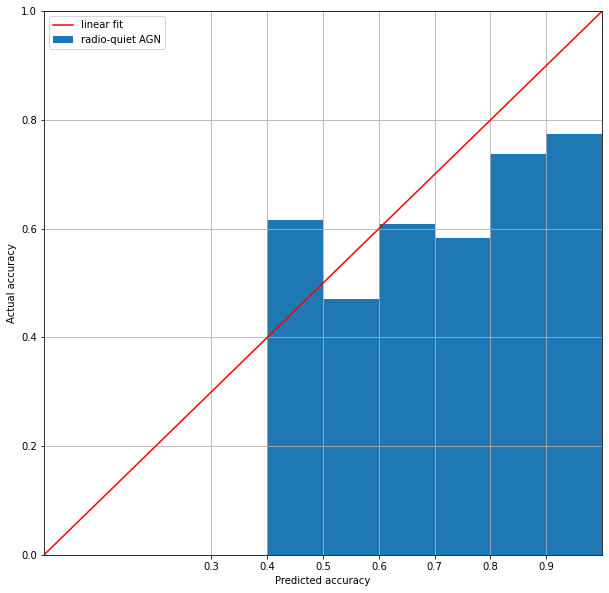

In [536]:
plt.figure(figsize=(10,10))
plt.bar(range_beginning+0.05, all_accuracies[2], width=0.1, label=labels[2])
plt.plot([0,1],[0,1], c='r', label='linear fit')
plt.grid()
plt.xticks(range_beginning)
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

print(all_samples[2])

[5, 34, 223, 254, 349, 616, 8048]


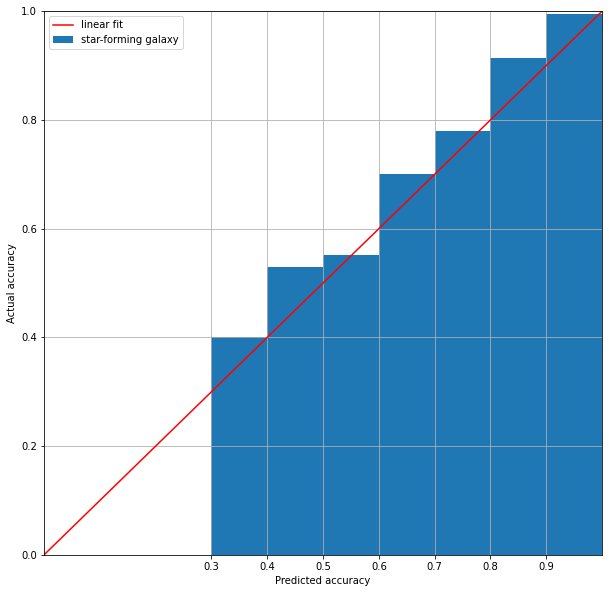

In [535]:
plt.figure(figsize=(10,10))
plt.bar(range_beginning+0.05, all_accuracies[3], width=0.1, label=labels[3])
plt.plot([0,1],[0,1], c='r', label='linear fit')
plt.grid()
plt.xticks(range_beginning)
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

print(all_samples[3])

In [555]:
y_pred = model.predict_proba(X_test)

In [585]:
factors = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
best_acc = 0
for f1 in factors:
    for f2 in factors:
        for f3 in factors:
            for f4 in factors:   
                factor = np.array([f1, f2, f3, f4])
                y_pred = model.predict_proba(X_val)*factor
                y_pred = np.argmax(y_pred, axis=1)
                
                accuracy = accuracy_score(y_val ,y_pred)
                if accuracy>best_acc:
                    best_acc = accuracy
                    best_factor = factor

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
C:\Users\jespe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the approp

In [587]:
best_factor

array([0.5, 0.4, 0.1, 0.3])

In [572]:
model2 = XGBClassifier(use_label_encoder=False, 
                      max_depth=1, 
                      eta=0.3, # Remember to reduce to 0.1 or 0.05 for better results
                      tree_method='gpu_hist', # exact is more precies, but this is much faster
                      gpu_id=0,
                      eval_metric=['merror'],
                      objective='multi:softprob',
                      #feval=precision_metric,
                      nthread=8,
                      n_estimators=10000,
                      )

In [573]:
bst = model2.fit(model.predict_proba(X_train), y_train, 
                eval_set=[
                    (model.predict_proba(X_train), y_train),
                    (model.predict_proba(X_val), y_val)
                ], 
                early_stopping_rounds=100,
                verbose=True, 
                #sample_weight=classes_weights,
                #eval_metric=precision_metric
               ) #

[0]	validation_0-merror:0.00834	validation_1-merror:0.09749
[1]	validation_0-merror:0.00739	validation_1-merror:0.09860
[2]	validation_0-merror:0.00708	validation_1-merror:0.09722
[3]	validation_0-merror:0.00708	validation_1-merror:0.09722
[4]	validation_0-merror:0.00748	validation_1-merror:0.09722
[5]	validation_0-merror:0.00748	validation_1-merror:0.09722
[6]	validation_0-merror:0.00748	validation_1-merror:0.09722
[7]	validation_0-merror:0.00719	validation_1-merror:0.09694
[8]	validation_0-merror:0.00720	validation_1-merror:0.09694
[9]	validation_0-merror:0.00720	validation_1-merror:0.09694
[10]	validation_0-merror:0.00709	validation_1-merror:0.09722
[11]	validation_0-merror:0.00713	validation_1-merror:0.09722
[12]	validation_0-merror:0.00713	validation_1-merror:0.09722
[13]	validation_0-merror:0.00713	validation_1-merror:0.09749
[14]	validation_0-merror:0.00713	validation_1-merror:0.09722
[15]	validation_0-merror:0.00713	validation_1-merror:0.09722
[16]	validation_0-merror:0.00713	v

[134]	validation_0-merror:0.00609	validation_1-merror:0.09694
[135]	validation_0-merror:0.00609	validation_1-merror:0.09694
[136]	validation_0-merror:0.00609	validation_1-merror:0.09694
[137]	validation_0-merror:0.00609	validation_1-merror:0.09667
[138]	validation_0-merror:0.00609	validation_1-merror:0.09694


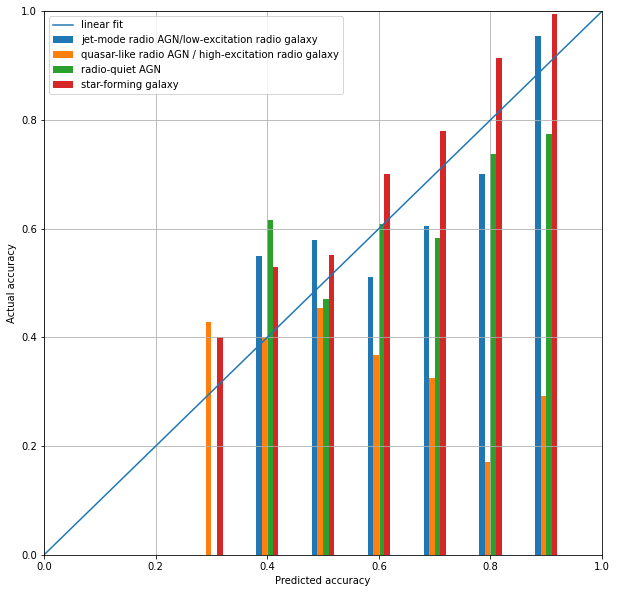

In [511]:
plt.figure(figsize=(10,10))
for i, a in enumerate(all_accuracies):
    plt.bar(range_beginning-0.015+i/100, a, width=0.01, label=labels[i])
plt.plot([0,1],[0,1], label='linear fit')
plt.grid()
plt.xlabel('Predicted accuracy')
plt.ylabel('Actual accuracy')
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend()

In [40]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8863    0.8575    0.8716      3754
quasar-like radio AGN / high-excitation radio galaxy     0.6259    0.2796    0.3866       329
                                     radio-quiet AGN     0.7679    0.6532    0.7059      1165
                                 star-forming galaxy     0.9134    0.9572    0.9348      9975

                                            accuracy                         0.8947     15223
                                           macro avg     0.7984    0.6869    0.7247     15223
                                        weighted avg     0.8894    0.8947    0.8899     15223



### Accuracy report per data set

#### Original

In [30]:
y_pred = model.predict(X_test[X_test.index<77609])
print(classification_report(y_test[X_test.index<77609], y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.8531    0.7987    0.8250      1992
quasar-like radio AGN / high-excitation radio galaxy     0.7009    0.3505    0.4673       214
                                     radio-quiet AGN     0.7771    0.6724    0.7210      1099
                                 star-forming galaxy     0.9225    0.9613    0.9415      9076

                                            accuracy                         0.8990     12381
                                           macro avg     0.8134    0.6957    0.7387     12381
                                        weighted avg     0.8946    0.8990    0.8950     12381



#### B&H

In [31]:
y_pred = model.predict(X_test[(X_test.index>=77609) & (X_test.index<=90770)])
print(classification_report(y_test[(X_test.index>=77609) & (X_test.index<=90770)], y_pred, target_names=labels[[0,1,3]], digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.9501    0.9625    0.9563      1602
quasar-like radio AGN / high-excitation radio galaxy     0.4138    0.1644    0.2353        73
                                 star-forming galaxy     0.8777    0.9241    0.9003       435

                                            accuracy                         0.9270      2110
                                           macro avg     0.7472    0.6837    0.6973      2110
                                        weighted avg     0.9166    0.9270    0.9198      2110



### MIGHTEE

In [33]:
y_pred = model.predict(X_test[X_test.index>90770])
print(classification_report(y_test[X_test.index>90770], y_pred, target_names=labels, digits=4))

                                                      precision    recall  f1-score   support

      jet-mode radio AGN/low-excitation radio galaxy     0.5972    0.5375    0.5658       160
quasar-like radio AGN / high-excitation radio galaxy     0.4545    0.1190    0.1887        42
                                     radio-quiet AGN     0.5500    0.3333    0.4151        66
                                 star-forming galaxy     0.7840    0.9073    0.8412       464

                                            accuracy                         0.7295       732
                                           macro avg     0.5964    0.4743    0.5027       732
                                        weighted avg     0.7032    0.7295    0.7051       732



## SHAP

In [30]:
import shap
shap.initjs()

In [31]:
mapping = {'Total_flux': 'Total 150 MHz',
           'Peak_flux': 'Peak 150 MHz', 
           'NUV_flux_corr': 'NUV', 
           'u_flux_corr': 'u',
           'Bw_flux_corr': r'$B_w$', 
           'R_flux_corr': 'R', 
           'I_flux_corr': 'I', 
           'z_flux_corr': 'z',
           'y_flux_corr': 'y', 
           'J_flux_corr': 'J', 
           'H_flux_corr': 'H', 
           'K_flux_corr': 'K',
           'Ks_flux_corr': r'$K_s$', 
           'ch1_flux_corr': 'ch1', 
           'ch2_flux_corr': 'ch2', 
           'ch3_flux_corr': 'ch3',
           'ch4_flux_corr': 'ch4', 
           'F_MIPS_24': 'MIPS24', 
           'F_PACS_100': 'PACS100', 
           'F_PACS_160': 'PACS160', 
           'F_SPIRE_250': 'SPIRE250',
           'F_SPIRE_350': 'SPIRE350', 
           'F_SPIRE_500': 'SPIRE500', 
           'Z_BEST': 'Redshift', 
           'g_flux_corr': 'g',
           'nb921_hsc_flux_corr': 'NB921'}

In [32]:
shap_values = shap.TreeExplainer(model, check_additivity=False).shap_values(X_train, check_additivity=False)

In [33]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22, "axes.labelsize": 200})

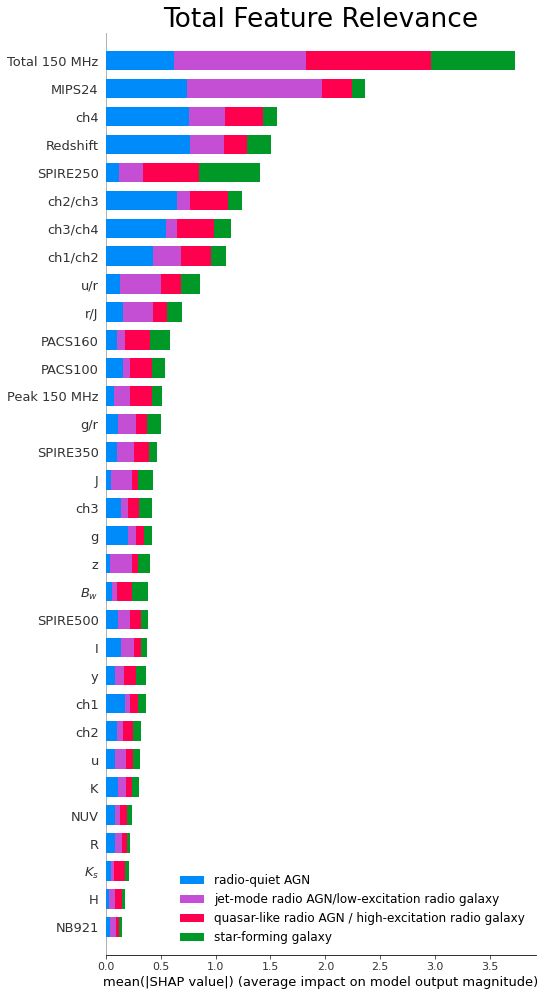

In [34]:
shap.summary_plot(shap_values, X_train.rename(columns=mapping), class_names=labels, max_display=999, show=False)
plt.title("Total Feature Relevance")
plt.tight_layout()
plt.savefig("Total_feature_relevance.pdf")

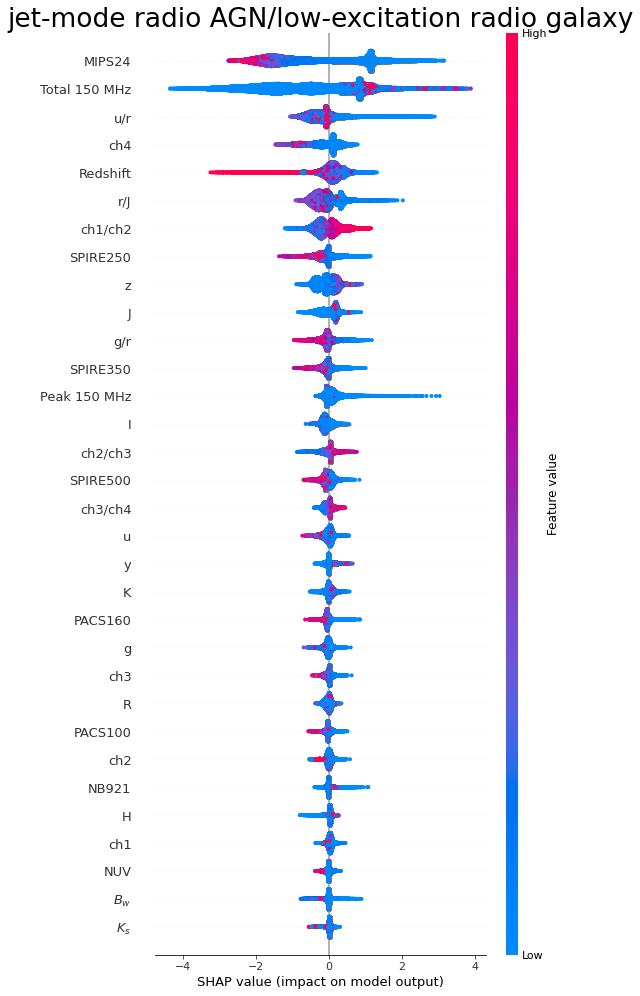

In [35]:
shap.summary_plot(shap_values[0], X_train.rename(columns=mapping), show=False, max_display=999)
plt.title(labels[0])
plt.tight_layout()
plt.savefig("LERG_relevance.pdf")
plt.show()

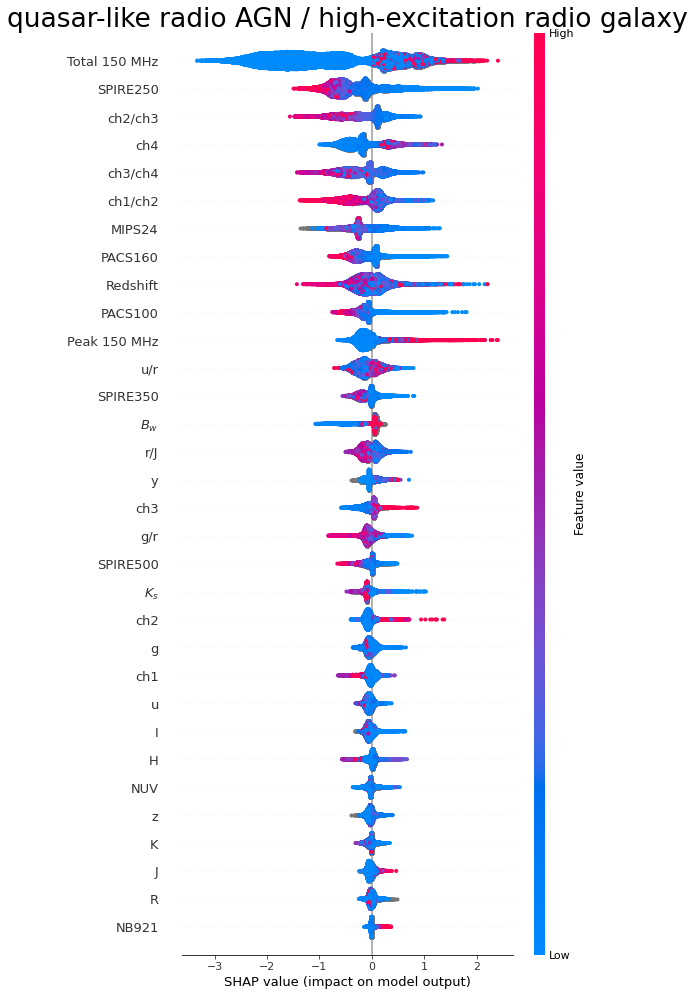

In [36]:
shap.summary_plot(shap_values[1], X_train.rename(columns=mapping), show=False, max_display=999)
plt.title(labels[1])
plt.tight_layout()
plt.savefig("HERG_relevance.pdf")
plt.show()

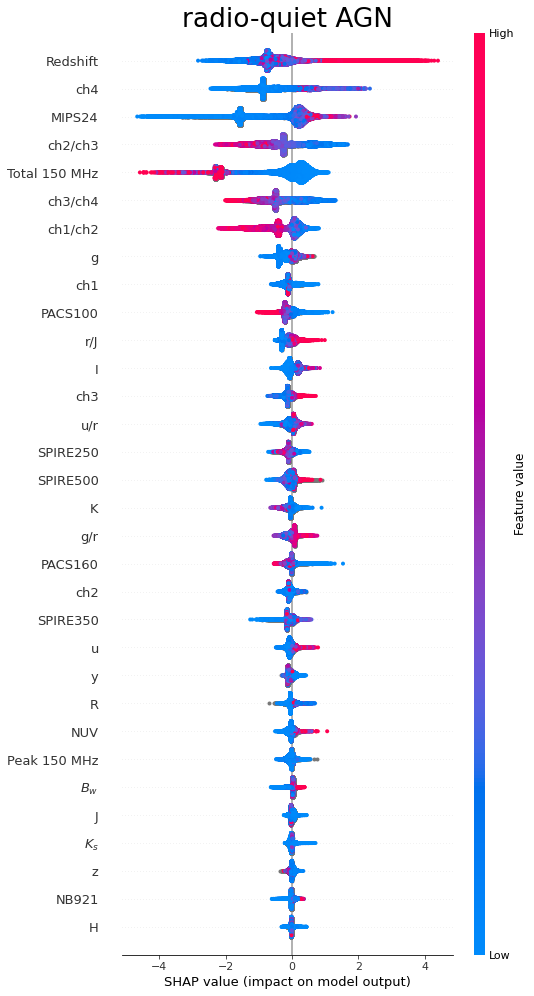

In [37]:
shap.summary_plot(shap_values[2], X_train.rename(columns=mapping).rename(columns=mapping), show=False, max_display=999)
plt.title(labels[2])
plt.tight_layout()
plt.savefig("RQ_relevance.pdf")
plt.show()

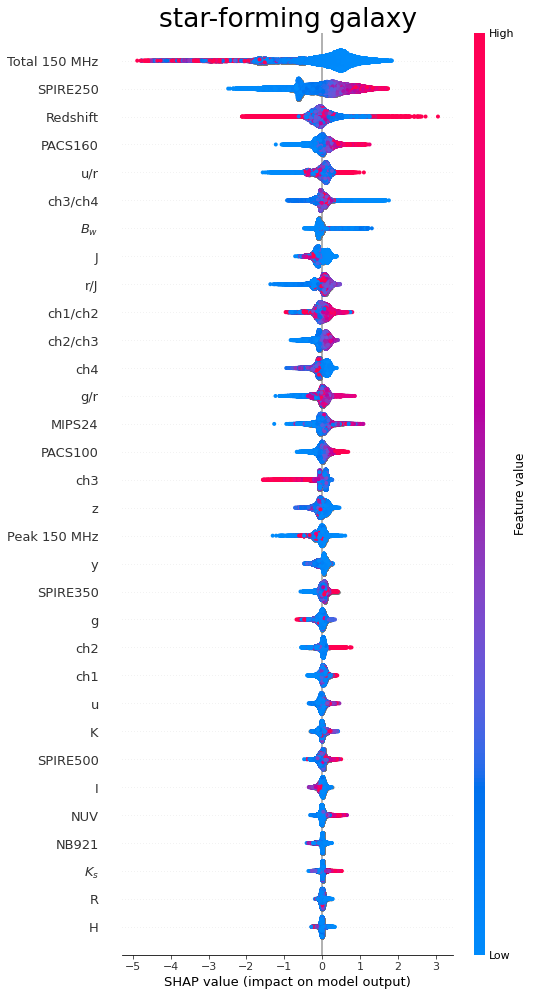

In [38]:
shap.summary_plot(shap_values[3], X_train.rename(columns=mapping).rename(columns=mapping), show=False, max_display=999)
plt.title(labels[3])
plt.tight_layout()
plt.savefig("SFG_relevance.pdf")
plt.show()

### Bayesian optimisation

In [28]:
from bayes_opt import BayesianOptimization

In [29]:
def optimise_xgboost(max_depth, 
                     reg_alpha, 
                     reg_lambda, 
                     min_child_weight, 
                     eta,
                     max_delta_step,
                     n_estimators):
    # The algorithm gives floats, so we round them
    n_estimators = int(n_estimators)
    max_depth = int(max_depth)
    
    model = XGBClassifier(use_label_encoder=False, 
                      max_depth=max_depth, 
                      reg_alpha=reg_alpha,   
                      min_child_weight=min_child_weight, 
                      reg_lambda=reg_lambda,
                      max_delta_step=max_delta_step,
                      eta=eta,
                      tree_method='hist',
                      #gpu_id=0,
                      objective='multi:softprob',
                      eval_metric =['merror'],
                      nthread=8,
                      n_estimators=n_estimators
                      )
    
    y_preds = []
    for train_index, val_index in skf.split(X_train, y_train):    
        # Splitting up the new train and test set (from the original train set)
        X_train_cv, X_val = X_train[train_index], X_train[val_index]
        y_train_cv, y_val = y_train[train_index], y_train[val_index]

        # Training the model, no early stopping
        model.fit(X_train_cv, y_train_cv, 
                    verbose=False, 
                   )

        # Getting the accuracy and appending
        y_pred = model.predict(X_val)
        y_preds.append(accuracy_score(y_val, y_pred))
    return np.mean(y_preds)

In [30]:
# Bounded region of parameter space
pbounds = {
    'max_depth': (5, 20),
    'reg_alpha': (0, 5),
    'reg_lambda': (0, 10),
    'min_child_weight': (0, 5),
    'eta': (0.05, 0.6),
    'max_delta_step': (0,10),
    'n_estimators': (10,1000)
}

In [22]:
from sklearn.model_selection import StratifiedKFold

# Getting k folds for cross validation
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y, random_state=42)

skf = StratifiedKFold(n_splits=8)

# Needed for cv
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

print(skf)

StratifiedKFold(n_splits=8, random_state=None, shuffle=False)


In [32]:
optimizer = BayesianOptimization(
    f=optimise_xgboost,
    pbounds=pbounds,
    verbose=2, # verbose = 1 prints only when a maximum is observed, verbose = 0 is silent
    random_state=42,
)

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    optimizer.maximize(
        init_points=5,
        n_iter=100,
    )

|   iter    |  target   |    eta    | max_de... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------------------
| 1         | 0.8952    | 0.256     | 9.507     | 15.98     | 2.993     | 164.5     | 0.78      | 0.5808    |
| 2         | 0.8941    | 0.5264    | 6.011     | 15.62     | 0.1029    | 970.2     | 4.162     | 2.123     |
| 3         | 0.898     | 0.15      | 1.834     | 9.564     | 2.624     | 437.6     | 1.456     | 6.119     |
| 4         | 0.8977    | 0.1267    | 2.921     | 10.5      | 2.28      | 787.3     | 0.9984    | 5.142     |
| 5         | 0.8958    | 0.3758    | 0.4645    | 14.11     | 0.8526    | 74.4      | 4.744     | 9.656     |
| 6         | 0.8964    | 0.4141    | 6.536     | 13.48     | 4.212     | 446.5     | 4.024     | 7.866     |
| 7         | 0.896     | 0.5692    | 3.268     | 10.08     | 1.197     | 437.0     | 2.364     | 5.719     |
| 8       

| 45        | 0.8966    | 0.5685    | 6.449     | 5.175     | 3.693     | 942.2     | 3.034     | 5.716     |
| 46        | 0.8972    | 0.3       | 2.126     | 5.41      | 3.294     | 294.6     | 3.674     | 9.196     |
| 47        | 0.8971    | 0.2476    | 5.802     | 16.56     | 1.078     | 971.8     | 1.96      | 6.533     |
| 48        | 0.8956    | 0.5384    | 9.301     | 13.43     | 4.547     | 718.6     | 0.3897    | 1.942     |
| 49        | 0.8974    | 0.1097    | 7.182     | 14.1      | 4.441     | 446.6     | 2.819     | 8.214     |
| 50        | 0.8975    | 0.5415    | 1.162     | 9.901     | 1.405     | 449.6     | 4.022     | 6.818     |
| 51        | 0.8973    | 0.2589    | 7.704     | 18.69     | 2.891     | 660.1     | 2.17      | 9.075     |
| 52        | 0.8977    | 0.3381    | 2.609     | 11.07     | 2.476     | 437.0     | 0.622     | 5.295     |
| 53        | 0.8982    | 0.3603    | 3.375     | 9.758     | 3.102     | 436.7     | 0.9107    | 6.555     |
| 54      

In [48]:
# Important note here: the splitting is done in such a way that class balance AND source balance is maintained
# See y.value_counts
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, stratify=y[['Source', 'Classification']], random_state=42)

model = XGBClassifier(use_label_encoder=False, 
                      max_depth=8, 
                      reg_alpha=4.389,   
                      min_child_weight=0.3662, 
                      reg_lambda=8.856,
                      max_delta_step=9.844,
                      eta=0.08451,
                      tree_method='hist',
                      #gpu_id=0,
                      objective='multi:softprob',
                      eval_metric =['merror'],
                      nthread=16,
                      n_estimators=991,
                      random_state=42
                      )

In [29]:
X_train['ch1/ch2'] = X_train['ch1_flux_corr']/X_train['ch2_flux_corr']
X_train['ch2/ch3'] = X_train['ch2_flux_corr']/X_train['ch3_flux_corr']
X_train['ch3/ch4'] = X_train['ch3_flux_corr']/X_train['ch4_flux_corr']
X_train['ch3/ch4'] = X_train['ch3_flux_corr']/X_train['ch4_flux_corr']
X_train['r/J'] = X_train['R_flux_corr']/X_train['J_flux_corr']
X_train['u/r'] = X_train['u_flux_corr']/X_train['R_flux_corr']
X_train['g/r'] = X_train['g_flux_corr']/X_train['R_flux_corr']

model.fit(X_train, y_train['Classification'])

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.08451,
              eval_metric=['merror'], gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.0845099986, max_delta_step=9.844, max_depth=8,
              min_child_weight=0.3662, missing=nan, monotone_constraints='()',
              n_estimators=991, n_jobs=16, nthread=16, num_parallel_tree=1,
              objective='multi:softprob', random_state=42, reg_alpha=4.389,
              reg_lambda=8.856, scale_pos_weight=None, subsample=1,
              tree_method='hist', use_label_encoder=False,
              validate_parameters=1, ...)

#### Cross-validation

In [23]:
scores_subgroups = pd.DataFrame(columns=['Source', 'Accuracy', 'Precision', 'Recall', 'F1', 'Ratio'])
detection_sources = pd.DataFrame(columns=['Xray', 'Opt_spec',
       'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])
non_detection_sources = pd.DataFrame(columns=['Xray', 'Opt_spec',
       'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

In [24]:
# We need to do a hacky trick so we can stratify over both columns
y_train['Combined'] = y_train['Classification'].astype(str) + y_train['Source'].astype(str)

NameError: name 'y_train' is not defined

In [ ]:
y_test[y_test['Source'] == 'BH']['Classification'].value_counts()

In [387]:
X_train['ch1/ch2'] = X_train['ch1_flux_corr']/X_train['ch2_flux_corr']
X_train['ch2/ch3'] = X_train['ch2_flux_corr']/X_train['ch3_flux_corr']
X_train['ch3/ch4'] = X_train['ch3_flux_corr']/X_train['ch4_flux_corr']
X_train['ch3/ch4'] = X_train['ch3_flux_corr']/X_train['ch4_flux_corr']
X_train['r/J'] = X_train['R_flux_corr']/X_train['J_flux_corr']
X_train['u/r'] = X_train['u_flux_corr']/X_train['R_flux_corr']
X_train['g/r'] = X_train['g_flux_corr']/X_train['R_flux_corr']

In [393]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

n = 16
skf = StratifiedKFold(n_splits=n)

precisions = []
recalls = []
f1s = []
accuracies = []

# Confusion matrices
cm_all = []
cm_original = []
cm_BH = []
cm_MIGHTEE = []

i = 0
# Important note here: the stratified k-fold is done in such a way that class balance AND source balance is maintained
# See y_train.value_counts

# We also need to convert y_train in the split to labels, but that is easily done with a label encoder
for train_index, test_index in skf.split(X_train, y_train['Combined']):
    print(f"{(i+1)/n*100}% Done")
    X_train_cv, X_test_cv = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_cv, y_test_cv = y_train.iloc[train_index], y_train.iloc[test_index]
    
    model.fit(X_train_cv, y_train_cv['Classification'], verbose=False)

    y_pred = model.predict(X_test_cv)
    
    # Confusion matrix
    cm = confusion_matrix(y_test_cv['Classification'], y_pred)
    cm_all.append(cm)
    
    # Class-specific scores
    precision = precision_score(y_test_cv['Classification'], y_pred, average=None, labels=[0, 1, 2, 3])
    recall = recall_score(y_test_cv['Classification'], y_pred, average=None, labels=[0, 1, 2, 3])
    f1 = f1_score(y_test_cv['Classification'], y_pred, average=None, labels=[0, 1, 2, 3])
    
    # General scores
    accuracy = accuracy_score(y_test_cv['Classification'], y_pred)
    
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)
    accuracies.append(accuracy)
    
    # New row for the (non-)detections dataframe, this is essentially a confusion matrix
    cm_row = []
    for detection in ['Xray', 'Opt_spec', 'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']:
        sub_x_test = X_test_cv[y_test_cv[detection] == True]
        sub_y_test = y_test_cv[y_test_cv[detection] == True]
        
        y_pred = model.predict(sub_x_test)
        
        
        cm = confusion_matrix(sub_y_test['Classification'], y_pred, labels=[0, 1, 2, 3])
        cm_row.append(cm)

    newrow = pd.DataFrame(data=[cm_row], 
                          columns=['Xray', 'Opt_spec', 
                                   'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

    detection_sources = pd.concat([detection_sources, newrow], ignore_index=True)
    
    cm_row = []
    for detection in ['Xray', 'Opt_spec', 'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN']:
        sub_x_test = X_test_cv[y_test_cv[detection] == False]
        sub_y_test = y_test_cv[y_test_cv[detection] == False]
        
        y_pred = model.predict(sub_x_test)
        
        
        cm = confusion_matrix(sub_y_test['Classification'], y_pred, labels=[0, 1, 2, 3])
        cm_row.append(cm)

    newrow = pd.DataFrame(data=[cm_row], 
                          columns=['Xray', 'Opt_spec', 
                                   'IRAGN', 'Donley', 'XAGN', 'midIRAGN', 'VLBAAGN', 'RLAGN', 'optAGN'])

    non_detection_sources = pd.concat([non_detection_sources, newrow], ignore_index=True)
    
    # Scores in subgroups
    for source in ['Original', 'BH', 'MIGHTEE']:      
        # Finding the subgroups
        sub_x_test = X_test_cv[y_test_cv['Source'] == source]
        sub_y_test = y_test_cv[y_test_cv['Source'] == source]
        
        y_pred = model.predict(sub_x_test)
        
        # Confusion matrix
        cm = confusion_matrix(sub_y_test['Classification'], y_pred)
        if source == 'Original':
            cm_original.append(cm)
        elif source == 'BH':
            cm_BH.append(cm)
        elif source == 'MIGHTEE':
            cm_MIGHTEE.append(cm)
        
        # Class-specific scores
        precision = precision_score(sub_y_test['Classification'], y_pred, average=None, zero_division=0, labels=[0, 1, 2, 3])
        recall = recall_score(sub_y_test['Classification'], y_pred, average=None, zero_division=0, labels=[0, 1, 2, 3])
        f1 = f1_score(sub_y_test['Classification'], y_pred, average=None, zero_division=0, labels=[0, 1, 2, 3])

        # General scores
        accuracy = accuracy_score(sub_y_test['Classification'], y_pred)
        
        # Ratio of sources
        ratio = sub_y_test['Classification'].value_counts()
        
        # appending row to scores dataframe
        data = [[source, accuracy, precision, recall, f1, ratio]]
        newrow = pd.DataFrame(data=data, 
                              columns=['Source', 'Accuracy', 'Precision', 'Recall', 'F1', 'Ratio'])
        
        scores_subgroups = pd.concat([scores_subgroups, newrow], ignore_index=True)
        
    

    i+=1

6.25% Done
12.5% Done
18.75% Done
25.0% Done
31.25% Done
37.5% Done
43.75% Done
50.0% Done
56.25% Done
62.5% Done
68.75% Done
75.0% Done
81.25% Done
87.5% Done
93.75% Done
100.0% Done


In [340]:
from matplotlib import rcParams, rcParamsDefault
rcParams.update(rcParamsDefault)

In [362]:
detection_sources

Xray  \
0   [[0, 0, 0, 0], [2, 3, 2, 0], [0, 1, 17, 6], [0...   
1   [[0, 0, 0, 0], [3, 5, 2, 0], [0, 0, 22, 9], [0...   
2   [[0, 0, 0, 0], [2, 2, 1, 1], [0, 1, 16, 5], [0...   
3   [[0, 0, 0, 0], [2, 3, 1, 1], [0, 2, 16, 5], [0...   
4   [[0, 0, 0, 0], [2, 3, 1, 2], [0, 1, 13, 6], [0...   
5   [[0, 0, 0, 0], [0, 2, 1, 1], [0, 0, 18, 1], [0...   
6   [[0, 0, 0, 0], [2, 4, 2, 1], [1, 0, 18, 4], [0...   
7   [[0, 0, 0, 0], [1, 3, 2, 0], [0, 2, 10, 3], [0...   
8   [[0, 0, 0, 0], [4, 3, 1, 0], [1, 0, 21, 2], [0...   
9   [[0, 0, 0, 0], [5, 0, 0, 1], [2, 3, 15, 9], [0...   
10  [[0, 0, 0, 0], [3, 2, 3, 1], [0, 0, 26, 2], [0...   
11  [[0, 0, 0, 0], [1, 4, 4, 0], [0, 0, 8, 5], [0,...   
12  [[0, 0, 0, 0], [3, 2, 0, 0], [0, 0, 14, 4], [0...   
13  [[0, 0, 0, 0], [2, 2, 2, 1], [0, 1, 18, 5], [0...   
14  [[0, 0, 0, 0], [5, 2, 1, 0], [0, 2, 19, 5], [0...   
15  [[0, 0, 0, 0], [4, 2, 1, 0], [1, 1, 16, 5], [0...   

                                             Opt_spec  \
0   [[0, 0, 0, 0], [0, 6, 0, 3], [0, 2, 57, 11], [...   
1   [[0, 0, 0, 0], [0, 4, 3, 2], [1, 1, 66, 11], [...   
2   [[0, 0, 0, 0], [5, 4, 3, 0], [0, 1, 44, 10], [...   
3   [[0, 0, 0, 0], [3, 5, 3, 1], [0, 1, 65, 10], [...   
4   [[0, 0, 0, 0], [2, 7, 3, 1], [1, 1, 66, 8], [0...   
5   [[0, 0, 0, 0], [3, 7, 4, 1], [0, 0, 63, 10], [...   
6   [[0, 0, 0, 0], [1, 9, 3, 0], [0, 0, 60, 7], [0...   
7   [[0, 0, 0, 0], [2, 6, 4, 0], [1, 2, 60, 9], [0...   
8   [[0, 0, 0, 0], [1, 9, 3, 1], [0, 2, 44, 11], [...   
9   [[0, 0, 0, 0], [2, 5, 2, 1], [0, 2, 55, 5], [0...   
10  [[0, 0, 0, 0], [1, 6, 1, 0], [1, 1, 59, 11], [...   
11  [[0, 0, 0, 0], [1, 6, 5, 0], [0, 2, 45, 11], [...   
12  [[0, 0, 0, 0], [1, 7, 3, 1], [3, 0, 47, 11], [...   
13  [[0, 0, 0, 0], [3, 8, 3, 1], [1, 2, 53, 16], [...   
14  [[0, 0, 0, 0], [0, 2, 4, 0], [0, 1, 59, 16], [...   
15  [[0, 0, 0, 0], [6, 9, 7, 1], [0, 3, 47, 6], [0...   

                                                IRAGN  \
0   [[11, 1, 0, 4], [4, 14, 5, 3], [0, 2, 130, 13]...   
1   [[9, 4, 0, 3], [3, 9, 9, 1], [0, 3, 128, 15], ...   
2   [[10, 0, 2, 3], [3, 19, 6, 0], [3, 2, 125, 19]...   
3   [[8, 4, 0, 3], [3, 12, 11, 0], [1, 3, 152, 21]...   
4   [[8, 4, 1, 5], [1, 17, 8, 1], [0, 4, 135, 20],...   
5   [[4, 1, 0, 2], [4, 15, 10, 0], [0, 2, 120, 16]...   
6   [[2, 3, 2, 5], [3, 19, 3, 0], [2, 4, 143, 17],...   
7   [[5, 2, 0, 1], [3, 15, 8, 1], [0, 3, 141, 14],...   
8   [[7, 1, 0, 2], [1, 20, 8, 0], [3, 2, 127, 19],...   
9   [[3, 2, 1, 5], [3, 12, 9, 3], [0, 4, 133, 13],...   
10  [[8, 1, 1, 5], [5, 11, 8, 2], [0, 3, 139, 15],...   
11  [[7, 3, 0, 8], [2, 13, 12, 1], [2, 3, 129, 18]...   
12  [[10, 1, 0, 2], [2, 14, 10, 0], [0, 2, 135, 20...   
13  [[10, 2, 0, 3], [1, 15, 8, 2], [0, 2, 140, 20]...   
14  [[8, 0, 0, 3], [1, 17, 7, 0], [1, 4, 131, 14],...   
15  [[9, 1, 1, 2], [2, 15, 9, 1], [1, 0, 121, 15],...   

                                               Donley  \
0   [[13, 1, 0, 7], [3, 14, 5, 3], [1, 3, 132, 15]...   
1   [[10, 4, 0, 5], [3, 9, 10, 1], [0, 2, 142, 17]...   
2   [[12, 0, 2, 2], [4, 17, 6, 0], [3, 2, 132, 21]...   
3   [[9, 3, 0, 3], [4, 13, 11, 0], [1, 3, 152, 22]...   
4   [[8, 4, 1, 5], [2, 16, 8, 2], [0, 4, 141, 20],...   
5   [[4, 1, 1, 2], [4, 15, 11, 0], [0, 2, 131, 20]...   
6   [[6, 3, 2, 5], [3, 21, 4, 0], [2, 4, 145, 17],...   
7   [[4, 2, 0, 3], [4, 14, 8, 1], [0, 4, 146, 12],...   
8   [[8, 1, 0, 3], [1, 19, 7, 0], [3, 2, 131, 18],...   
9   [[5, 2, 1, 6], [2, 12, 10, 3], [0, 4, 130, 17]...   
10  [[10, 1, 1, 5], [6, 11, 9, 2], [0, 3, 147, 15]...   
11  [[8, 3, 0, 9], [2, 13, 12, 1], [2, 3, 135, 18]...   
12  [[10, 1, 0, 3], [2, 14, 10, 0], [0, 2, 140, 20...   
13  [[10, 2, 0, 3], [3, 16, 9, 2], [0, 2, 141, 23]...   
14  [[7, 0, 0, 4], [1, 19, 6, 1], [1, 4, 135, 16],...   
15  [[9, 1, 2, 3], [2, 14, 10, 1], [1, 1, 125, 18]...   

                                                 XAGN  \
0   [[0, 0, 0, 0], [5, 0, 0, 5], [3, 0, 7, 4], [0,...   
1   [[0, 0, 0, 0], [5, 2, 2, 1], [0, 1, 5, 10], [0...  

In [382]:
detection_sources.sum(axis=0).iloc[4]

array([[  0,   0,   0,   0],
       [ 69,  22,  23,  53],
       [ 36,   6,  88, 100],
       [  0,   0,   0,   0]])

In [402]:
cm_correct

array([[ 135,   33,    9,   63],
       [  43,  244,  127,   22],
       [  13,   39, 2190,  311],
       [  21,   22,  297, 1045]])

In [403]:
135+33+9+63

240

In [411]:
cm_correct.sum(axis=1)

array([0.85446009, 0.78773585, 1.02852486, 1.0425    ])

In [428]:
temp = 
temp

array([[0.63679245, 0.15566038, 0.04245283, 0.29716981],
       [0.12721893, 0.72189349, 0.37573964, 0.06508876],
       [0.00495616, 0.01486847, 0.83492185, 0.11856653],
       [0.01457321, 0.01526718, 0.20610687, 0.72519084]])

In [435]:
detection_sources.iloc[:,1]

0     [[0, 0, 0, 0], [0, 6, 0, 3], [1, 2, 54, 13], [...
1     [[0, 0, 0, 0], [0, 4, 4, 1], [1, 1, 65, 12], [...
2     [[0, 0, 0, 0], [5, 4, 3, 0], [0, 1, 44, 10], [...
3     [[0, 0, 0, 0], [3, 5, 3, 1], [1, 1, 64, 10], [...
4     [[0, 0, 0, 0], [3, 7, 3, 0], [1, 0, 67, 8], [0...
5     [[0, 0, 0, 0], [2, 8, 4, 1], [1, 0, 62, 10], [...
6     [[0, 0, 0, 0], [1, 8, 4, 0], [0, 0, 61, 6], [0...
7     [[0, 0, 0, 0], [3, 6, 2, 1], [1, 2, 60, 9], [0...
8     [[0, 0, 0, 0], [0, 9, 3, 2], [0, 2, 45, 10], [...
9     [[0, 0, 0, 0], [2, 4, 3, 1], [0, 2, 53, 7], [0...
10    [[0, 0, 0, 0], [2, 4, 2, 0], [1, 1, 57, 13], [...
11    [[0, 0, 0, 0], [1, 7, 4, 0], [0, 2, 45, 11], [...
12    [[0, 0, 0, 0], [1, 9, 1, 1], [3, 0, 46, 12], [...
13    [[0, 0, 0, 0], [3, 8, 3, 1], [1, 2, 52, 17], [...
14    [[0, 0, 0, 0], [0, 3, 2, 1], [1, 1, 60, 14], [...
15    [[0, 0, 0, 0], [5, 10, 6, 2], [0, 3, 47, 6], [...
Name: Opt_spec, dtype: object

In [472]:
temp = detection_sources.sum(axis=0).iloc[i]
temp.sum(axis=0)

array([ 21,  16, 107,  61])

In [477]:
temp

array([[ 0,  0,  0,  0],
       [11, 13, 17, 11],
       [10,  3, 90, 50],
       [ 0,  0,  0,  0]])

In [ ]:
# Can compare relative performance of 2 detection techniques
i = 6
k = 3
print(f'First detection technique: {detection_sources.columns[i]} with sample size: {detection_sources.iloc[:,i].sum().sum()}')
print(f'First detection technique: {detection_sources.columns[k]} with sample size: {detection_sources.iloc[:,k].sum().sum()}')

cm_has_label1 = detection_sources.sum(axis=0).iloc[i]
cm_has_label1 = cm_has_label1/cm_has_label1.sum(axis=1)[:, np.newaxis]
cm_has_label2 = detection_sources.sum(axis=0).iloc[k]
cm_has_label2 = cm_has_label2/cm_has_label2.sum(axis=1)[:, np.newaxis]

fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_has_label1, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

First detection technique: VLBAAGN with sample size: 178
First detection technique: Donley with sample size: 4614


invalid value encountered in true_divide


In [196]:
scores_subgroups

Empty DataFrame
Columns: [Source, Accuracy, Precision, Recall, F1, Ratio]
Index: []

##### Complete dataset

In [116]:
precisions = np.array(precisions)
recalls = np.array(recalls)
f1s = np.array(f1s)
accuracies = np.array(accuracies)

In [117]:
precisions_means = np.mean(precisions, axis=0)
precisions_std = np.std(precisions, axis=0)

recalls_means = np.mean(recalls, axis=0)
recalls_std = np.std(recalls, axis=0)

f1s_means = np.mean(f1s, axis=0)
f1s_std = np.std(f1s, axis=0)

In [118]:
for i in range(4):
    print(f"{labels[i]}")
    print()
    print(f"Precision: {precisions_means[i]} ± {precisions_std[i]}")
    print(f"Recall: {recalls_means[i]} ± {recalls_std[i]}")
    print(f"F1-score: {f1s_means[i]} ± {f1s_std[i]}")
    print("--------------------------------------------------------------")
print(f"Accuracy: {np.mean(accuracies)} ± {np.std(accuracies)}")

print(f"Macro average precision: {np.mean(precisions)} ± {np.std(precisions)}")
print(f"Macro average recall: {np.mean(recalls)} ± {np.std(recalls)}")
print(f"Macro average F1: {np.mean(f1s)} ± {np.std(f1s)}")

jet-mode radio AGN/low-excitation radio galaxy

Precision: 0.8915060863027564 ± 0.008273179898841066
Recall: 0.862647133853105 ± 0.008694391157232976
F1-score: 0.8767962791044761 ± 0.005857657650182227
--------------------------------------------------------------
quasar-like radio AGN / high-excitation radio galaxy

Precision: 0.6063005549050244 ± 0.05905367850578436
Recall: 0.30593701492919795 ± 0.03697125125382961
F1-score: 0.4060449235660734 ± 0.04330748303858345
--------------------------------------------------------------
radio-quiet AGN

Precision: 0.7852560498444641 ± 0.017648036830161327
Recall: 0.6744529896732575 ± 0.025412762890229954
F1-score: 0.725347573648073 ± 0.017509148905237734
--------------------------------------------------------------
star-forming galaxy

Precision: 0.9160438529854292 ± 0.0038658477957261095
Recall: 0.9571921952141035 ± 0.0032467413769044495
F1-score: 0.9361614535910762 ± 0.0029257493933074826
----------------------------------------------------

In [119]:
def error_in_sum(stds):
    return np.sqrt(sum(stds**2))

ratio = np.unique(y_train['Classification'], return_counts=True)[1] 
ratio = ratio/sum(ratio)

print(f"Weighted average precision: {sum(ratio*precisions_means)} ± {error_in_sum(ratio*precisions_std)}")
print(f"Weighted average recall: {sum(ratio*recalls_means)} ± {error_in_sum(ratio*recalls_std)}")
print(f"Weighted average F1: {sum(ratio*f1s_means)} ± {error_in_sum(ratio*f1s_std)}")

Weighted average precision: 0.8932907360826763 ± 0.0037459000691784415
Weighted average recall: 0.8981672824365765 ± 0.0036800554196003243
Weighted average F1: 0.8939335961097568 ± 0.0029039852780957704


In [120]:
precisions_std

array([0.00827318, 0.05905368, 0.01764804, 0.00386585])

##### Per dataset

In [121]:
dat = scores_subgroups[scores_subgroups['Source'] == 'Original']
np.std(dat.Precision.to_numpy())

array([0.01693852, 0.06417104, 0.01906781, 0.00384326])

In [122]:
for source in ['Original', 'BH', 'MIGHTEE']:
    # Just selecting the source
    dat = scores_subgroups[scores_subgroups['Source'] == source]
    
    precisions_means = np.mean(dat.Precision.to_numpy(), axis=0)
    precisions_std = np.std(dat.Precision.to_numpy(), axis=0)

    recalls_means = np.mean(dat.Recall.to_numpy(), axis=0)
    recalls_std = np.std(dat.Recall.to_numpy(), axis=0)

    f1s_means = np.mean(dat.F1.to_numpy(), axis=0)
    f1s_std = np.std(dat.F1.to_numpy(), axis=0)
    
    print(source)
    for i in range(4):
        print(f"{labels[i]}")
        print()
        print(f"Precision: {precisions_means[i]} ± {precisions_std[i]}")
        print(f"Recall: {recalls_means[i]} ± {recalls_std[i]}")
        print(f"F1-score: {f1s_means[i]} ± {f1s_std[i]}")
        print("--------------------------------------------------------------")
    print(f"Accuracy: {np.mean(dat['Accuracy'])} ± {np.std(dat['Accuracy'])}")

    # I hate storing lists in dataframes
    precisions_grouped = np.array(list(dat.Precision.to_numpy()))
    recalls_grouped = np.array(list(dat.Recall.to_numpy()))
    f1s_grouped = np.array(list(dat.F1.to_numpy()))
    
    # Finding the total ratio by taking the average
    ratio = dat.Ratio.apply(lambda x: x.sort_index())
    ratio = ratio.div(ratio.sum(axis=1), axis=0)
    ratio = ratio.sum(axis=0)/len(ratio)
    
    # For BH we need to ignore the 3rd column, since that doesn't have RQ
    if source != 'BH':
        print(f"Macro average precision: {np.mean(precisions_grouped)} ± {np.std(precisions_grouped)}")
        print(f"Macro average recall: {np.mean(recalls_grouped)} ± {np.std(recalls_grouped)}")
        print(f"Macro average F1: {np.mean(f1s_grouped)} ± {np.std(f1s_grouped)}")

        print(f"Weighted average precision: {sum(ratio*precisions_means)} ± {error_in_sum(ratio*precisions_std)}")
        print(f"Weighted average recall: {sum(ratio*recalls_means)} ± {error_in_sum(ratio*recalls_std)}")
        print(f"Weighted average F1: {sum(ratio*f1s_means)} ± {error_in_sum(ratio*f1s_std)}")
    else:
        print(f"Macro average precision: {np.mean(precisions_grouped[:,[0,1,3]])} ± {np.std(precisions_grouped[:,[0,1,3]])}")
        print(f"Macro average recall: {np.mean(recalls_grouped[:,[0,1,3]])} ± {np.std(recalls_grouped[:,[0,1,3]])}")
        print(f"Macro average F1: {np.mean(f1s_grouped[:,[0,1,3]])} ± {np.std(f1s_grouped[:,[0,1,3]])}")

        print(f"Weighted average precision: {sum(ratio*precisions_means[[0,1,3]])} ± {error_in_sum(ratio*precisions_std[[0,1,3]])}")
        print(f"Weighted average recall: {sum(ratio*recalls_means[[0,1,3]])} ± {error_in_sum(ratio*recalls_std[[0,1,3]])}")
        print(f"Weighted average F1: {sum(ratio*f1s_means[[0,1,3]])} ± {error_in_sum(ratio*f1s_std[[0,1,3]])}")
    print("------------------------------------------------------------------------------------")

Original
jet-mode radio AGN/low-excitation radio galaxy

Precision: 0.8666441358440187 ± 0.016938519499344107
Recall: 0.8025107498000892 ± 0.0161320262162089
F1-score: 0.8332167799468073 ± 0.01280177817546117
--------------------------------------------------------------
quasar-like radio AGN / high-excitation radio galaxy

Precision: 0.6301094279882375 ± 0.06417103575616442
Recall: 0.3621240388964269 ± 0.042142788942360815
F1-score: 0.4593502485608542 ± 0.04908509384223161
--------------------------------------------------------------
radio-quiet AGN

Precision: 0.7883889873573261 ± 0.019067805981043153
Recall: 0.6945089497593057 ± 0.02767496455085798
F1-score: 0.7381007825597854 ± 0.018189810226611706
--------------------------------------------------------------
star-forming galaxy

Precision: 0.9239466303206796 ± 0.003843259940470291
Recall: 0.9618202683615819 ± 0.003363509642129636
F1-score: 0.9424982146257826 ± 0.0029163714054130157
-----------------------------------------------

##### Confusion matrices

In [123]:
# Have to define own rounding function
def round_up(value, decimals):
    value = value * 10**decimals
    value = np.ceil(value)
    return value/10**decimals

In [338]:
cm_labels = ["LERG", "HERG", "RQ", "SFG"]

In [125]:
print(f'{np.round(cm_norm_row[i][j],4):.4f}')

0.9108


In [126]:
cm_norm_row_std[0][0]

0.07663109680523826

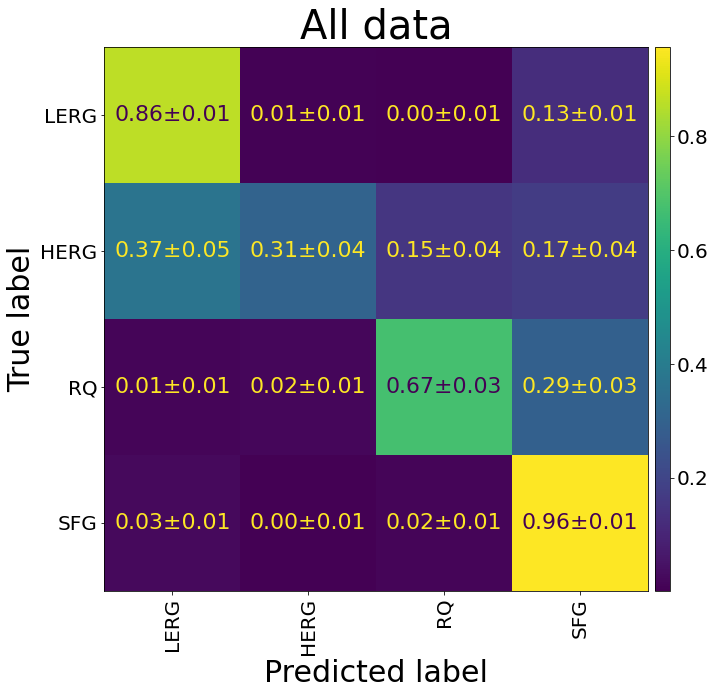

In [127]:
# Calculating the cm
cm_norm_row = np.array(cm_all).mean(axis=0)/np.array(cm_all).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_all).std(axis=0)/np.array(cm_all).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)

    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("All data", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('True label', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_all.pdf")
plt.show()

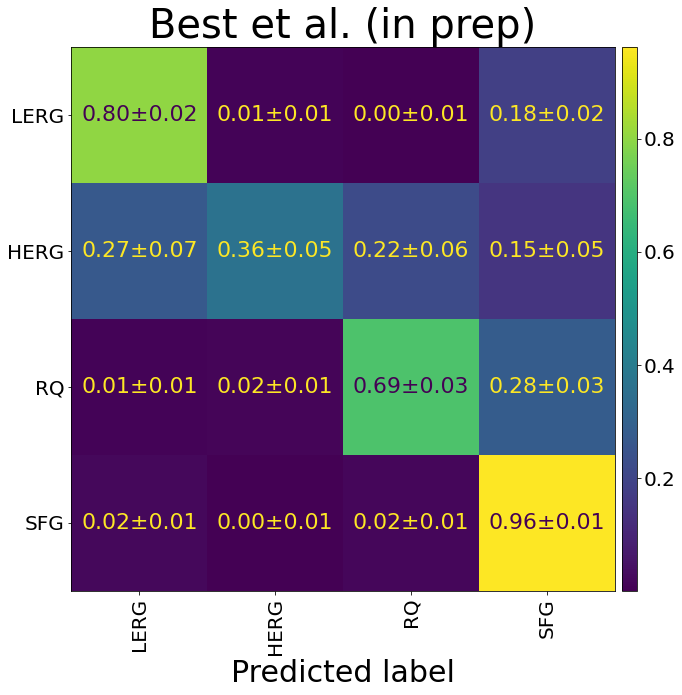

In [128]:
# Calculating the cm
cm_norm_row = np.array(cm_original).mean(axis=0)/np.array(cm_original).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_original).std(axis=0)/np.array(cm_original).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)

    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("Best et al. (in prep)", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_original.pdf")
plt.show()

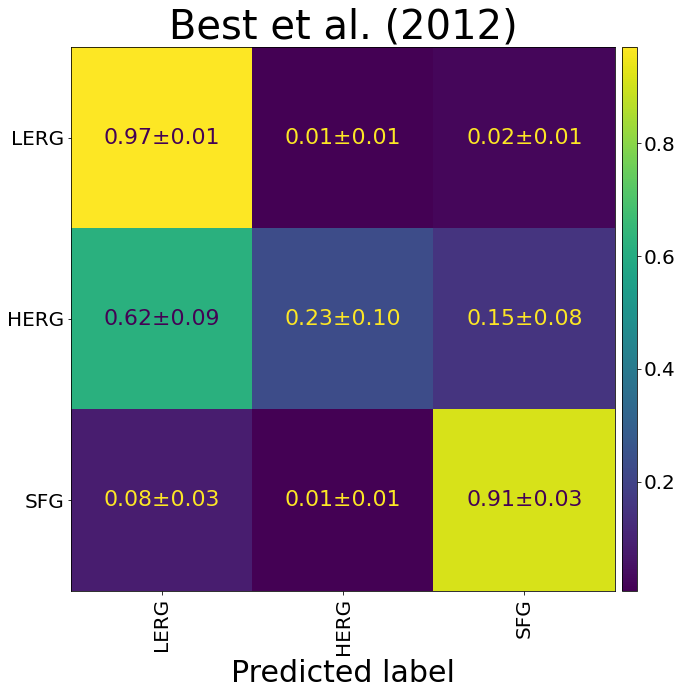

In [129]:
## Calculating the cm
cm_norm_row = np.array(cm_BH).mean(axis=0)/np.array(cm_BH).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_BH).std(axis=0)/np.array(cm_BH).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=['LERG', 'HERG', 'SFG'])
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(3):
    for j in range(3):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)

    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("Best et al. (2012)", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_BH.pdf")
plt.show()

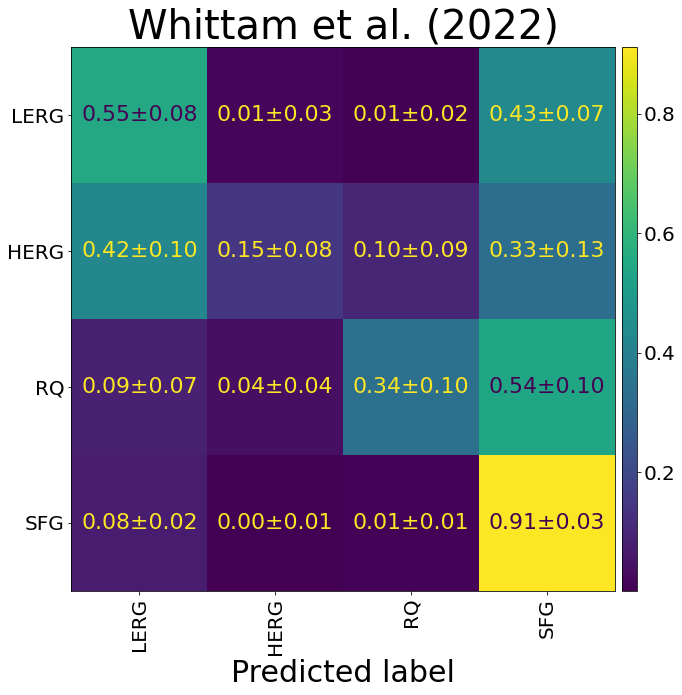

In [130]:
# Calculating the cm
cm_norm_row = np.array(cm_MIGHTEE).mean(axis=0)/np.array(cm_MIGHTEE).mean(axis=0).sum(axis=1)[:, np.newaxis]
cm_norm_row_std = np.array(cm_MIGHTEE).std(axis=0)/np.array(cm_MIGHTEE).mean(axis=0).sum(axis=1)[:, np.newaxis]

# Plotting
fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm_row, display_labels=cm_labels)
disp.plot(ax=ax, colorbar=False)

# Because sklearn is dumb we have to manually set the errors and such to 4 decimals this way
digits = 2
for i in range(4):
    for j in range(4):
        disp.text_[i][j].set_text(f'{np.round(cm_norm_row[i][j],digits):.{digits}f}±{round_up(cm_norm_row_std[i][j],digits):.{digits}f}')
        disp.text_[i][j].set_fontsize(22)

# X and y-ticks font size    
ax.tick_params(axis='both', which='major', labelsize=20)

    
# Rotating x-ticks
plt.xticks(rotation = 90)

# Setting title and axes (font sizes)
plt.title("Whittam et al. (2022)", fontsize=40)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('', fontsize=30)

# Adjust size of colorbar
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cax.tick_params(axis='both', which='major', labelsize=20)
plt.colorbar(disp.im_,  cax=cax)

plt.plot()
plt.savefig("CM_MIGHTEE.pdf")
plt.show()

In [39]:
y_pred = model.predict(X_test)


In [42]:
temp = X_test.copy()
temp['Predicted_label'] = le.inverse_transform(y_pred)
temp['Real_label'] = le.inverse_transform(y_test['Classification'])

In [44]:
temp.to_csv("temp.csv", index=False)

### Heatmap

In [25]:
y_pred = model.predict(X_test)
accuracy_score(y_test['Classification'], y_pred)

0.8973146250459825

In [28]:
data = X_test.copy()

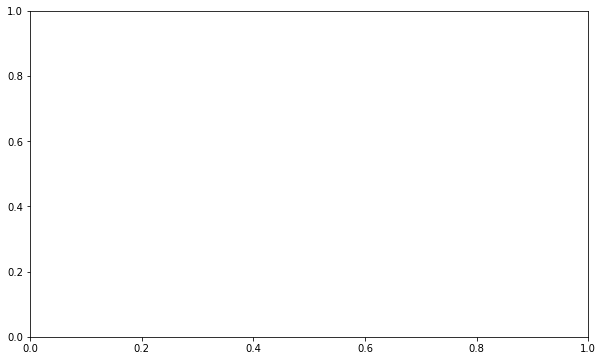

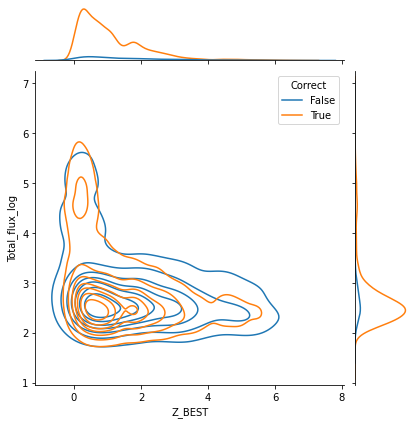

In [56]:
import seaborn as sns

data['Total_flux_log'] = np.log10(data['Total_flux'])

feature1 = 'Z_BEST'
feature2 = 'Total_flux_log'

correct = (y_pred == y_test['Classification'])

data['Correct'] = correct

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(10, 6))
sns.jointplot(data=data, x=feature1, y=feature2, hue='Correct', kind='kde', levels=8, common_norm=False)

<AxesSubplot:xlabel='Z_BEST', ylabel='Total_flux_log'>

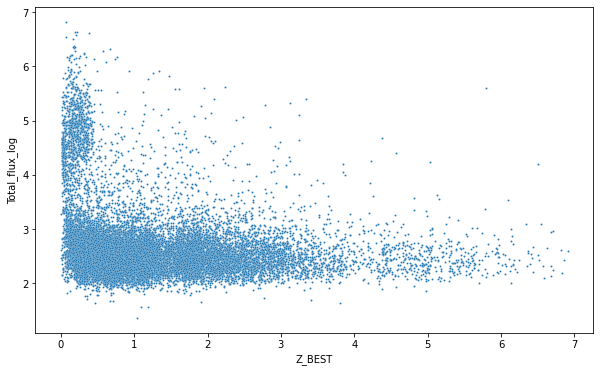

In [48]:
filt = (y_test['Source'] == 'MIGHTEE')

f, ax = plt.subplots(figsize=(10, 6))
sns.scatterplot(data=data, x=feature1, y=feature2, s=4)

In [39]:
y_test

Classification    Source
25958               3  Original
92629               0   MIGHTEE
64451               3  Original
89322               0        BH
73582               0  Original
...               ...       ...
44519               3  Original
62705               3  Original
23023               3  Original
13062               3  Original
67943               3  Original

[19029 rows x 2 columns]

In [6]:
temp = ['ENTREES', 'IJSSTUK', 'KLIEDER', 'RITSELT', 'SYSTEEM', 'STEKKIE', 'TERMINI']

In [7]:
for i in temp:
    print(len(i))

7
7
7
7
7
7
7


In [8]:
temp = ['DIPLOMA', 'DONDERS', 'GEBAAND', 'GANGPAD', 'KANDEEL', 'LASSING', 'SLIDING', 'AGOGIEK']

In [10]:
print(len('elfstedentocht'))

14
